# Машинное обучение-2: Глубокое обучение, РЭШ

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 15.03.2025

Жесткий дедлайн: 23:59MSK 22.03.2025

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

За домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from tqdm import trange
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from IPython.display import clear_output

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2025-03-22 15:30:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [ <=>                ] 201.24M  39.4MB/s    in 6.7s    

2025-03-22 15:30:24 (30.2 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [8]:
model = Ridge() # Define the model

# Scale features (X)
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

# Fit the model
model.fit(X_train_ss, y_train)
y_pred_ridge = model.predict(X_test_ss) # for out-of-sample prediction

# Display RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE Ridge: {rmse_ridge:.4f}")


RMSE Ridge: 9.5102


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [9]:
best_rmse_metric = np.power(np.mean(np.power((y_test - np.mean(y_train)), 2)), 0.5)
print(f'best_rmse_metric: {best_rmse_metric:.4f}')

best_rmse_metric: 10.8525


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [10]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Convert NumPy arrays to tensors and send to device
X_train_ss = torch.tensor(X_train_ss, dtype=torch.float32).to(device)
y_train_0 = torch.tensor(y_train, dtype=torch.float32).to(device)

# Define training dataset
dataset = TensorDataset(X_train_ss, y_train_0)

# Define butch loader
loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

### task 1

In [12]:
# Simple one linear layer NN
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define and move model to device
linreg = nn.Linear(X_train_ss.shape[1], 1).to(device)

### task 2

In [13]:
# Epoch training function
def train_one_epoch(model, dataloader, step_size):
    model.train()
    epoch_losses = []

    for x_batch, y_batch in tqdm(dataloader, desc="Training"):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        predictions = model(x_batch)
        rmse_loss = torch.sqrt(torch.mean((predictions - y_batch) ** 2))

        # Backward pass
        rmse_loss.backward()

        # Gradient update (if exist)
        with torch.no_grad():
            if model.weight.grad is not None:
                model.weight -= step_size * model.weight.grad
            if model.bias.grad is not None:
                model.bias -= step_size * model.bias.grad

        # Zero gradients
        model.zero_grad()

        # Record loss
        epoch_losses.append(rmse_loss.item())

    return np.mean(epoch_losses)


# Evaluation function
def evaluate_rmse(model, x_test, y_test):
    model.eval()

    # Convert to torch tensors if needed
    if isinstance(x_test, np.ndarray):
        x_test = torch.tensor(x_test, dtype=torch.float32)
    if isinstance(y_test, np.ndarray):
        y_test = torch.tensor(y_test, dtype=torch.float32)

    # Move tensors to the device
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():  # Disable gradient tracking
        predictions = model(x_test).squeeze()
        mse = torch.mean((predictions - y_test) ** 2)
        rmse = torch.sqrt(mse).cpu().item()
    return rmse

### Task 3

In [14]:
step_size = 0.05
epochs = 10
train_loss = []
test_loss = []

for epoch in tqdm(range(epochs), desc="Epochs"):
    train_rmse = train_one_epoch(linreg, loader, step_size)
    test_rmse = evaluate_rmse(linreg, X_test, y_test)

    train_loss.append(train_rmse)
    test_loss.append(test_rmse)

    # ✅ Print RMSE for this epoch
    print(f"Epoch {epoch + 1:2d} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  1 | Train RMSE: 1274.0480 | Test RMSE: 1122.9041


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  2 | Train RMSE: 111.0249 | Test RMSE: 208.5278


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  3 | Train RMSE: 10.5257 | Test RMSE: 188.0544


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  4 | Train RMSE: 10.5227 | Test RMSE: 237.3033


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  5 | Train RMSE: 10.5232 | Test RMSE: 320.6851


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  6 | Train RMSE: 10.5227 | Test RMSE: 368.9054


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  7 | Train RMSE: 10.5266 | Test RMSE: 518.3179


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  8 | Train RMSE: 10.5244 | Test RMSE: 311.0237


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch  9 | Train RMSE: 10.5159 | Test RMSE: 149.4165


Training:   0%|          | 0/28982 [00:00<?, ?it/s]

Epoch 10 | Train RMSE: 10.5212 | Test RMSE: 419.3230


### task 4

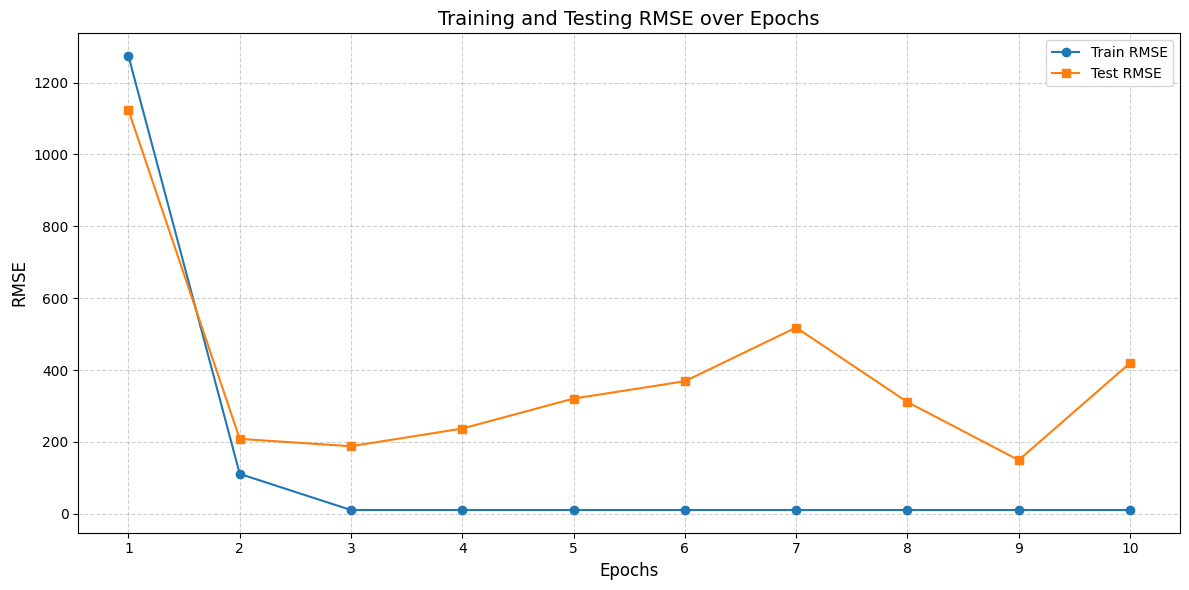

In [15]:
# Create a figure and set its size
plt.figure(figsize=(12, 6))

# Plot train and test loss across epochs
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='Train RMSE')
plt.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='s', label='Test RMSE')

# Add title and axis labels
plt.title('Training and Testing RMSE over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Add grid, legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(np.arange(1, len(train_loss) + 1))  # Ensure x-axis ticks match epoch numbers

plt.tight_layout()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [16]:
# Taking a random 10% sample for preliminary training
df_short = df.sample(frac=0.1, random_state=42)

X_short = df_short.iloc[:, 1:].values
y_short = df_short.iloc[:, 0].values

# Split into train/test (80/20 split)
train_size_short = int(0.8 * len(df_short))

X_train_short = X_short[:train_size_short, :]
y_train_short = y_short[:train_size_short]
X_test_short = X_short[train_size_short:, :]
y_test_short = y_short[train_size_short:]

In [17]:
# Choosing potential scalers
from sklearn.preprocessing import MaxAbsScaler

#### MaxAbsScaler
scaler = MaxAbsScaler()

# For 10% of dataset
# X_train_scaled = scaler.fit_transform(X_train_short)
# X_test_scaled = scaler.transform(X_test_short)
# y_train_scaled = scaler.fit_transform(y_train_short.reshape(-1, 1))
# y_test_scaled = scaler.transform(y_test_short.reshape(-1, 1))

# For the whole dataset
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))


###########  To tensor and device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)


### Train and test functions

In [18]:
def train(model, optimizer, criterion, train_loader, test_loader, device, scheduler=None):
    """
    Train the model for one epoch and return average train and test RMSE.
    Optionally update the learning rate scheduler based on test RMSE.
    """
    model.train()  # Set model to training mode
    train_rmse_list = []

    # Iterate over training batches
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear previous gradients

        outputs = model(inputs)  # Forward pass
        mse = criterion(outputs, targets)
        rmse = torch.sqrt(mse)  # Compute RMSE

        rmse.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        train_rmse_list.append(rmse.detach().item())  # Record batch RMSE

    avg_train_rmse = np.mean(train_rmse_list)

    # Evaluate model on test data
    model.eval()
    test_rmse_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            mse = criterion(outputs, targets)
            rmse = torch.sqrt(mse)
            test_rmse_list.append(rmse.detach().item())

    avg_test_rmse = np.mean(test_rmse_list)

    # Optionally update the scheduler based on test RMSE
    if scheduler is not None:
        scheduler.step(avg_test_rmse)

    return avg_train_rmse, avg_test_rmse


def test(model, test_loader, device):
    """
    Evaluate the model on test set and return all predictions as a numpy array.
    This iterates over the test_loader for memory efficiency.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds.append(preds.detach().cpu())

    # Concatenate all batch predictions into a single array
    return torch.cat(all_preds, dim=0).numpy()

### Unscaling RMSE function

In [19]:
def evaluate_rmse_unscaled(model, data_loader, y_scaler, device):
    """
    Evaluate RMSE on unscaled data for interpretability.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            preds = model(inputs).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.cpu().numpy())

    # Concatenate and inverse transform
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    preds_unscaled = y_scaler.inverse_transform(all_preds)
    targets_unscaled = y_scaler.inverse_transform(all_targets)

    rmse = np.sqrt(mean_squared_error(targets_unscaled, preds_unscaled))
    return rmse


### Different models

Was not sure what model to choose. After many attempts, found this one: https://github.com/milliemince/eBay-shipping-predictions. And liked it - just seemed logical enough - to push as many features as possible at first, while reducing their number by 2 each time. Decided to play with it a bit.

In [20]:
class FullyConnectedRegression(nn.Module):
    def __init__(self, input_dim, p=0.25):
        super(FullyConnectedRegression, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(16, 1)  # Final output layer for regression
        )

    def forward(self, x):
        return self.network(x)

In [21]:
set_random_seed(42)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)

test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)

model = FullyConnectedRegression(X_train_scaled.shape[1]).to(device)

# On the lecture I heard that it is one of the best optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, # Someone told me this is a nice learning rate
    betas=(0.9, 0.999),
    weight_decay=1e-8
)

criterion = nn.MSELoss()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000 — Train RMSE: 16.9207, Test RMSE: 16.9491
Epoch 2/1000 — Train RMSE: 9.1986, Test RMSE: 9.2069
Epoch 3/1000 — Train RMSE: 9.0114, Test RMSE: 9.0820
Epoch 4/1000 — Train RMSE: 8.8061, Test RMSE: 8.9319
Epoch 5/1000 — Train RMSE: 8.7810, Test RMSE: 8.9187
Epoch 6/1000 — Train RMSE: 8.7716, Test RMSE: 8.9071
Epoch 7/1000 — Train RMSE: 8.6666, Test RMSE: 8.8488
Epoch 8/1000 — Train RMSE: 8.6279, Test RMSE: 8.8429
Epoch 9/1000 — Train RMSE: 8.6085, Test RMSE: 8.8139
Epoch 10/1000 — Train RMSE: 8.6340, Test RMSE: 8.8664
Epoch 11/1000 — Train RMSE: 8.5399, Test RMSE: 8.7667
Epoch 12/1000 — Train RMSE: 8.5136, Test RMSE: 8.7623
Epoch 13/1000 — Train RMSE: 8.4924, Test RMSE: 8.7941
Epoch 14/1000 — Train RMSE: 8.4717, Test RMSE: 8.7573
Epoch 15/1000 — Train RMSE: 8.5240, Test RMSE: 8.8110
Epoch 16/1000 — Train RMSE: 8.4932, Test RMSE: 8.7767
Epoch 17/1000 — Train RMSE: 8.5708, Test RMSE: 8.8880
Epoch 18/1000 — Train RMSE: 8.4436, Test RMSE: 8.8333
Epoch 19/1000 — Train RMSE: 8.4201,

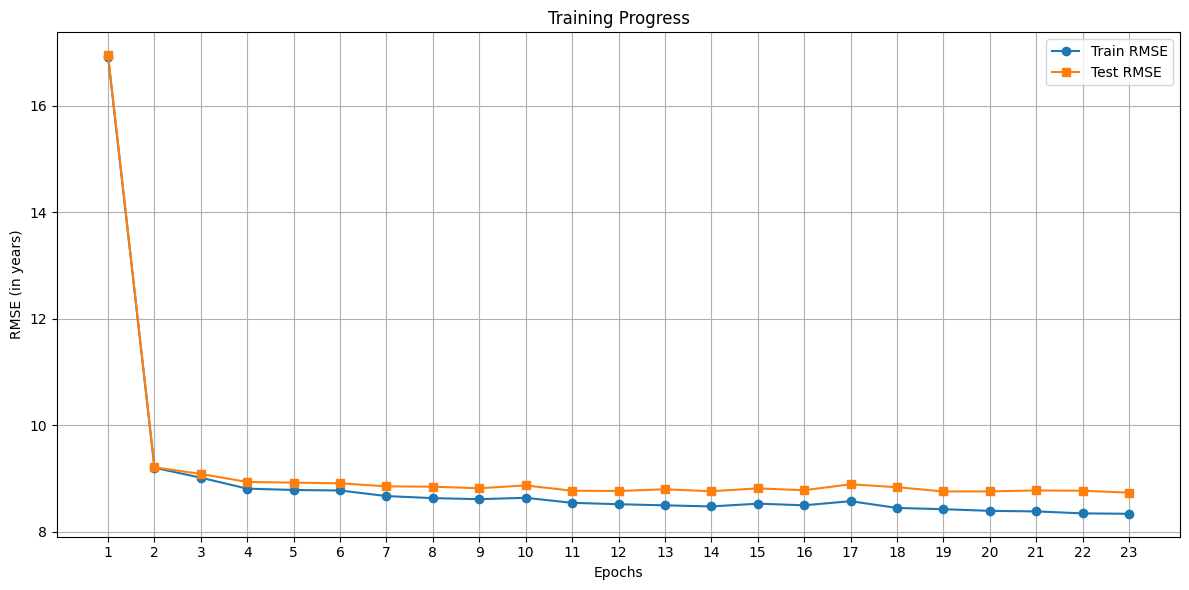

In [22]:
train_loss = []
test_loss = []
epochs = 1000
rmse_threshold = 8.75

for epoch in tqdm(range(epochs)):
    train(model, optimizer, criterion, train_loader, test_loader, device)

    # Calculate RMSE on original scale
    train_rmse = evaluate_rmse_unscaled(model, train_loader, scaler, device)
    test_rmse = evaluate_rmse_unscaled(model, test_loader, scaler, device)

    train_loss.append(train_rmse)
    test_loss.append(test_rmse)

    # Print RMSE for this epoch
    print(f"Epoch {epoch + 1}/{epochs} — Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Early stopping condition
    if test_rmse < rmse_threshold:
        print(f"Early stopping: Test RMSE reached {test_rmse:.4f} < {rmse_threshold} at epoch {epoch + 1}")
        print("bingo!")
        break

# Plot training progress up to the stopping point
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Train RMSE', marker='o')
plt.plot(np.arange(1, len(test_loss) + 1), test_loss, label='Test RMSE', marker='s')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('RMSE (in years)')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, len(train_loss) + 1))
plt.tight_layout()
plt.show()


Here is the model info (if needed):

In [23]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name} — shape: {param.shape}")
#         print(param.data)
#         print("-" * 50)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

For the scalar I took MaxAbsScaler - Googled that it was extremely helpful with sparse data. From the problem 0 - it seemed the case for our data.

For the architecture idea, I used the following GitHub publication:
https://github.com/milliemince/eBay-shipping-predictions.

I also decided to add BatchNorm. It was not a great idea - asked around- it appeared that I better use BatchNorm of Dropout, not both.

As eBay model  has more data for training - decided to remove the first, the largest layer. As for the shrinking structure- just liked it, as it was smth logical in this sea of chaos)

For the optimizer I utilied AdamW, as we discussed on the lecture that it is one of the best currently (Adam with momentum was a bit too tricky for me). All the parametrs are standard for Adam (lecture), except for learning rate - a friend of mine recommended to take lr=3e-4, as it is a golden rule one. I also tred to learn the learning rate, but results were worse. Even though the initial experiments are in my head, I will try to replicate some of them for illustrations.

### BatchNorm

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 — Train RMSE: 64.8789, Test RMSE: 64.9170
Epoch 2/15 — Train RMSE: 10.9931, Test RMSE: 10.9478
Epoch 3/15 — Train RMSE: 9.3200, Test RMSE: 9.3328
Epoch 4/15 — Train RMSE: 8.8912, Test RMSE: 9.0011
Epoch 5/15 — Train RMSE: 8.9071, Test RMSE: 8.9854
Epoch 6/15 — Train RMSE: 8.6795, Test RMSE: 8.8135
Epoch 7/15 — Train RMSE: 8.6507, Test RMSE: 8.8264
Epoch 8/15 — Train RMSE: 8.6446, Test RMSE: 8.7942
Epoch 9/15 — Train RMSE: 8.5693, Test RMSE: 8.7747
Epoch 10/15 — Train RMSE: 8.5082, Test RMSE: 8.7436
Epoch 11/15 — Train RMSE: 8.5350, Test RMSE: 8.7655
Epoch 12/15 — Train RMSE: 8.5495, Test RMSE: 8.7882
Epoch 13/15 — Train RMSE: 8.4380, Test RMSE: 8.7452
Epoch 14/15 — Train RMSE: 8.4145, Test RMSE: 8.7231
Epoch 15/15 — Train RMSE: 8.4347, Test RMSE: 8.7547


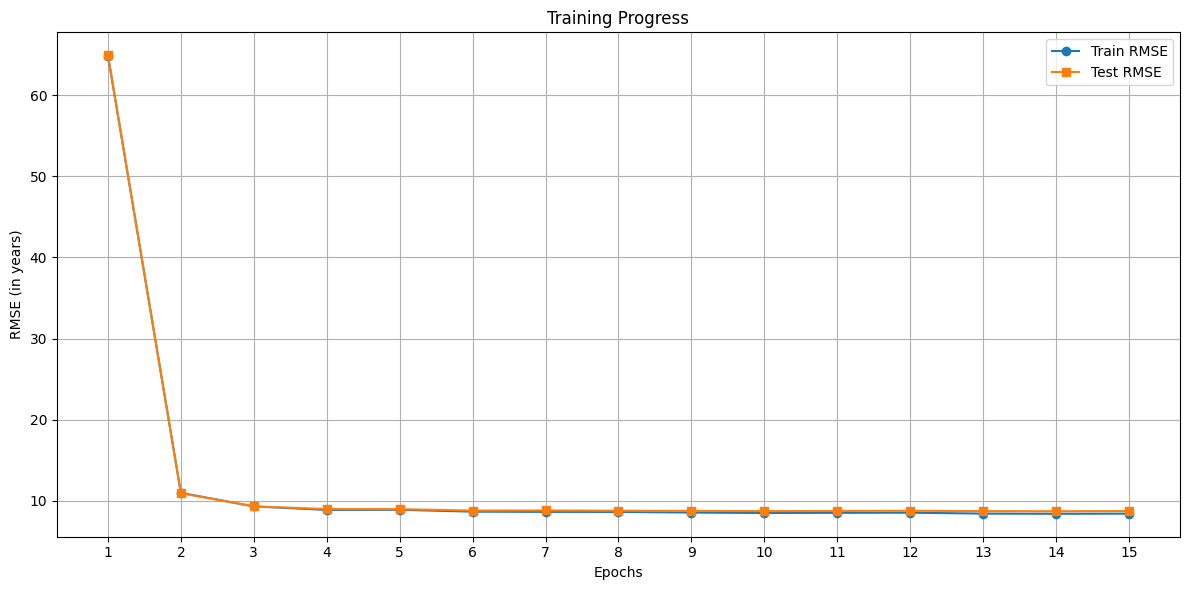

In [24]:
class FullyConnectedRegression(nn.Module):
    def __init__(self, input_dim, p=0.25):
        super(FullyConnectedRegression, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(16, 1)  # Final output layer (no BatchNorm, no activation)
        )

    def forward(self, x):
        return self.network(x)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)

test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)

model = FullyConnectedRegression(X_train_scaled.shape[1]).to(device)

# On the lecture I heard that it is one of the best optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, # Someone told me this is a nice learning rate
    betas=(0.9, 0.999),
    weight_decay=1e-8
)

criterion = nn.MSELoss()

train_loss = []
test_loss = []
epochs = 15

for epoch in tqdm(range(epochs)):
    train(model, optimizer, criterion, train_loader, test_loader, device)

    # Calculate RMSE on original scale
    train_rmse = evaluate_rmse_unscaled(model, train_loader, scaler, device)
    test_rmse = evaluate_rmse_unscaled(model, test_loader, scaler, device)

    train_loss.append(train_rmse)
    test_loss.append(test_rmse)

    # Print RMSE for this epoch
    print(f"Epoch {epoch + 1}/{epochs} — Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# Only show the plot AFTER all epochs are done
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs + 1), train_loss, label='Train RMSE', marker='o')
plt.plot(np.arange(1, epochs + 1), test_loss, label='Test RMSE', marker='s')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('RMSE (in years)')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, epochs + 1))
plt.tight_layout()
plt.show()

Well, may be I should have used this instead!) But the thing is- I tested each model on the 10% of the overall data- to save time. Seems like models (especially quite deep) tend to do better on the bigger datasets. But one thing for curtain - the initial guess (RMSE in 1st rediod) is higher, while the reduction of the learning rate is smoother... apparently) SO, may be combining BatchNorm and Dropout is not such a bad idea, at least for this problem and model.

### The Initial Ebay Model

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 — Train RMSE: 11.0546, Test RMSE: 10.9521
Epoch 2/15 — Train RMSE: 10.9403, Test RMSE: 10.8530
Epoch 3/15 — Train RMSE: 9.0787, Test RMSE: 9.0949
Epoch 4/15 — Train RMSE: 8.9497, Test RMSE: 9.0236
Epoch 5/15 — Train RMSE: 8.7704, Test RMSE: 8.9369
Epoch 6/15 — Train RMSE: 8.7371, Test RMSE: 8.8613
Epoch 7/15 — Train RMSE: 8.6362, Test RMSE: 8.8808
Epoch 8/15 — Train RMSE: 8.5648, Test RMSE: 8.8225
Epoch 9/15 — Train RMSE: 8.5742, Test RMSE: 8.7719
Epoch 10/15 — Train RMSE: 8.5377, Test RMSE: 8.8212
Epoch 11/15 — Train RMSE: 8.5170, Test RMSE: 8.7846
Epoch 12/15 — Train RMSE: 8.4253, Test RMSE: 8.7590
Epoch 13/15 — Train RMSE: 8.4202, Test RMSE: 8.7983
Epoch 14/15 — Train RMSE: 8.3830, Test RMSE: 8.8352
Epoch 15/15 — Train RMSE: 8.3668, Test RMSE: 8.7323


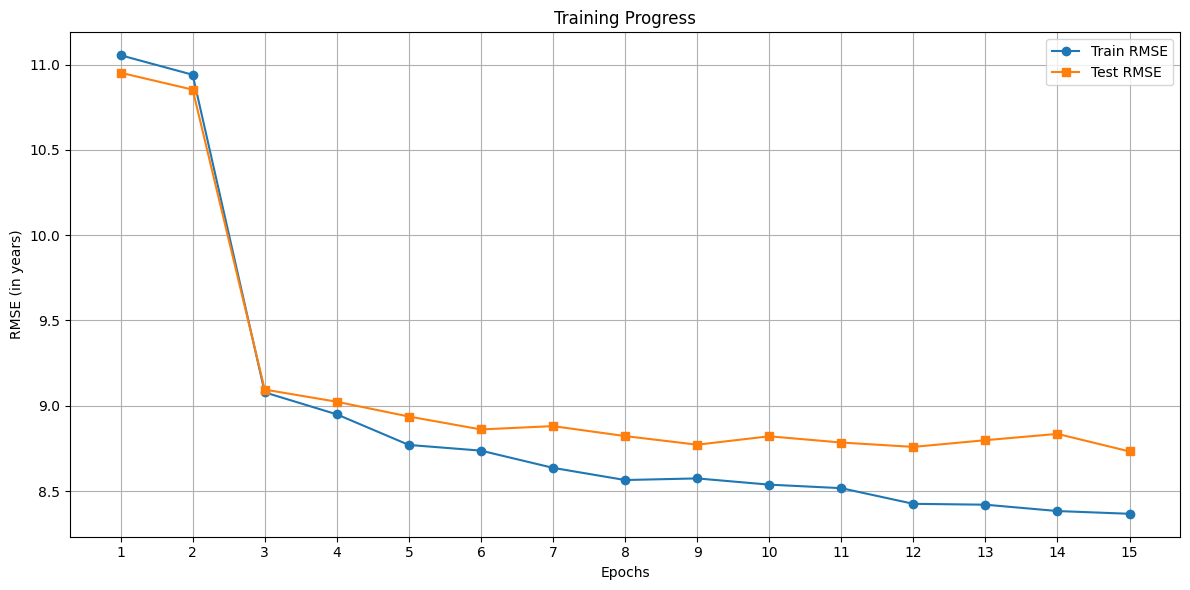

In [25]:
class FullyConnectedRegression(nn.Module):
    def __init__(self, input_dim=6, p=0.25):
        super(FullyConnectedRegression, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(16, 8),
            nn.ReLU(),

            nn.Linear(8, 1)  # Final regression output
        )

    def forward(self, x):
        return self.network(x)


train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)

test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)

model = FullyConnectedRegression(X_train_scaled.shape[1]).to(device)

# On the lecture I heard that it is one of the best optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, # Someone told me this is a nice learning rate
    betas=(0.9, 0.999),
    weight_decay=1e-8
)

criterion = nn.MSELoss()

train_loss = []
test_loss = []
epochs = 15

for epoch in tqdm(range(epochs)):
    train(model, optimizer, criterion, train_loader, test_loader, device)

    # Calculate RMSE on original scale
    train_rmse = evaluate_rmse_unscaled(model, train_loader, scaler, device)
    test_rmse = evaluate_rmse_unscaled(model, test_loader, scaler, device)

    train_loss.append(train_rmse)
    test_loss.append(test_rmse)

    # Print RMSE for this epoch
    print(f"Epoch {epoch + 1}/{epochs} — Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# Only show the plot AFTER all epochs are done
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs + 1), train_loss, label='Train RMSE', marker='o')
plt.plot(np.arange(1, epochs + 1), test_loss, label='Test RMSE', marker='s')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('RMSE (in years)')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, epochs + 1))
plt.tight_layout()
plt.show()

Well, the initial eBay model is far worse- well, it dropped to the curtain RMSE and stayed there - may be with more epochs it can work.

### Learning learning rate

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 — Train RMSE: 16.9207, Test RMSE: 16.9491
Epoch 2/15 — Train RMSE: 9.1986, Test RMSE: 9.2069
Epoch 3/15 — Train RMSE: 9.0114, Test RMSE: 9.0820
Epoch 4/15 — Train RMSE: 8.8061, Test RMSE: 8.9319
Epoch 5/15 — Train RMSE: 8.7810, Test RMSE: 8.9187
Epoch 6/15 — Train RMSE: 8.7716, Test RMSE: 8.9071
Epoch 7/15 — Train RMSE: 8.6666, Test RMSE: 8.8488
Epoch 8/15 — Train RMSE: 8.6279, Test RMSE: 8.8429
Epoch 9/15 — Train RMSE: 8.6085, Test RMSE: 8.8139
Epoch 10/15 — Train RMSE: 8.6340, Test RMSE: 8.8664
Epoch 11/15 — Train RMSE: 8.5399, Test RMSE: 8.7667
Epoch 12/15 — Train RMSE: 8.5136, Test RMSE: 8.7623
Epoch 13/15 — Train RMSE: 8.4924, Test RMSE: 8.7941
Epoch 14/15 — Train RMSE: 8.4717, Test RMSE: 8.7573
Epoch 15/15 — Train RMSE: 8.5240, Test RMSE: 8.8110


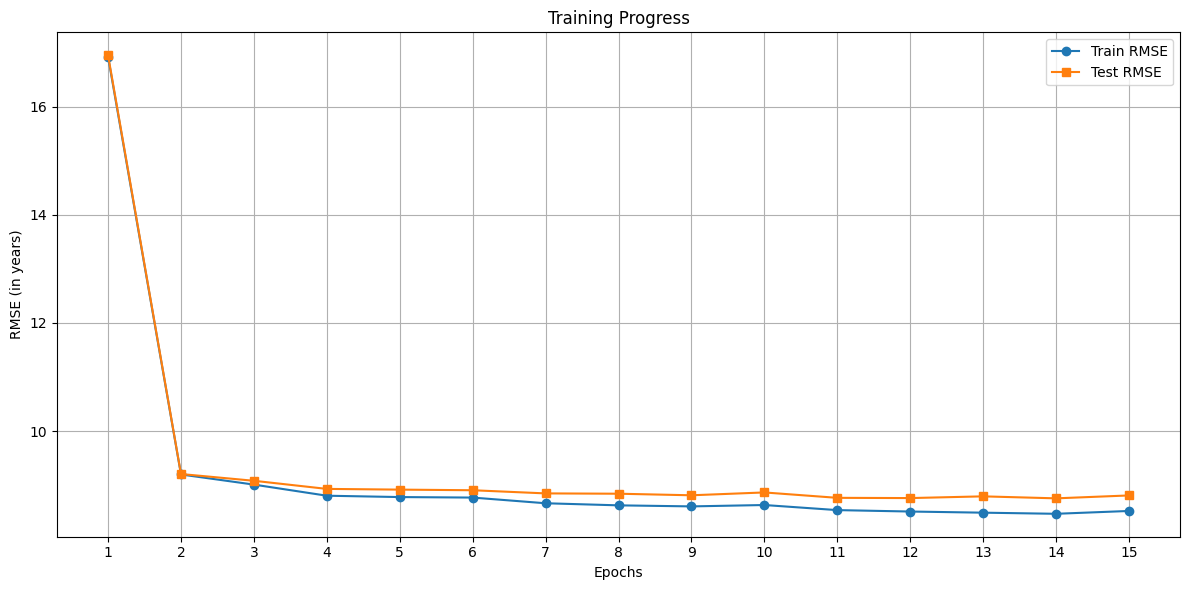

In [26]:
class FullyConnectedRegression(nn.Module):
    def __init__(self, input_dim, p=0.25):
        super(FullyConnectedRegression, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p),

            nn.Linear(16, 1)  # Final output layer for regression
        )

    def forward(self, x):
        return self.network(x)


set_random_seed(42)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)

test_set = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)

model = FullyConnectedRegression(X_train_scaled.shape[1]).to(device)

# On the lecture I heard that it is one of the best optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, # Someone told me this is a nice learning rate
    betas=(0.9, 0.999),
    weight_decay=1e-8
)
# I googled- this type ca describe the warm-up logit from the lecture
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,       # Number of epochs for the first restart
    T_mult=2,     # Multiply cycle length by this after each restart
    eta_min=1e-6  # Minimum learning rate
)
criterion = nn.MSELoss()

train_loss = []
test_loss = []
epochs = 15

for epoch in tqdm(range(epochs)):
    train(model, optimizer, criterion, train_loader, test_loader, device)

    # Calculate RMSE on original scale
    train_rmse = evaluate_rmse_unscaled(model, train_loader, scaler, device)
    test_rmse = evaluate_rmse_unscaled(model, test_loader, scaler, device)

    train_loss.append(train_rmse)
    test_loss.append(test_rmse)

    # Print RMSE for this epoch
    print(f"Epoch {epoch + 1}/{epochs} — Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# Only show the plot AFTER all epochs are done
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, epochs + 1), train_loss, label='Train RMSE', marker='o')
plt.plot(np.arange(1, epochs + 1), test_loss, label='Test RMSE', marker='s')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('RMSE (in years)')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(1, epochs + 1))
plt.tight_layout()
plt.show()

Well, RMSE pattern is actually the same as my main model, but slower) I guess, on the whole dataset there are many ways to get proper RMSE.

